Validation day is:  2024-07-01 00:00:00
The model output has the following 2 parameters with shape (N_time, N_lat, N_lon): 
NmF2 , shape  (96, 91, 91)
hmF2 , shape  (96, 91, 91)
Forming observation vectors:
Observation vector y has N_obs =  1144
Forming G:
G has shape [N_obs, N_time, N_lat, N_lon] =  (1144, 96, 91, 91)
Figure Ionosonde Map is saved at:  /data/vmakarevich/Download/Save/Ionosondes_Map.pdf
Figure Residuals is saved at:  /data/vmakarevich/Download/Save/Residuals.pdf
Figure Ionosonde Mean Residuals is saved at:  /data/vmakarevich/Download/Save/IonRes_NmF2.pdf
Figure Ionosonde Mean Residuals is saved at:  /data/vmakarevich/Download/Save/IonRes_hmF2.pdf


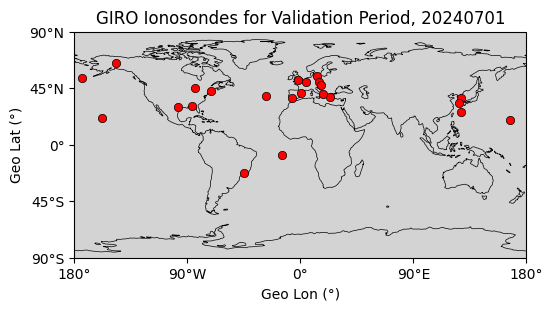

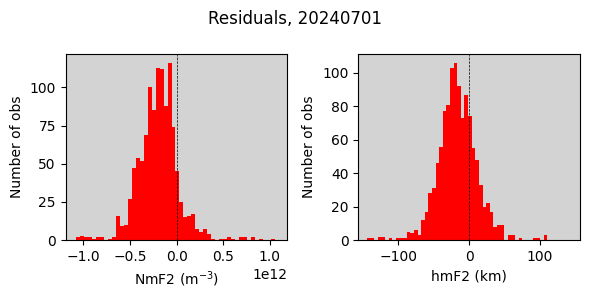

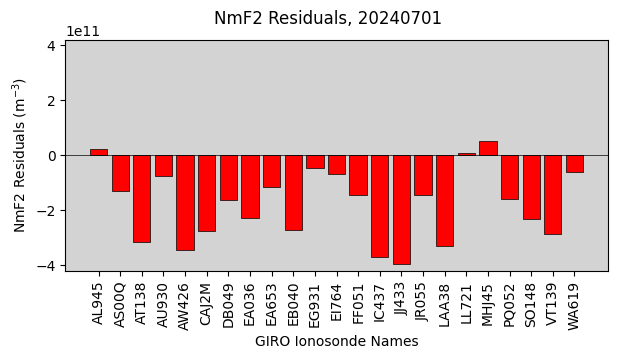

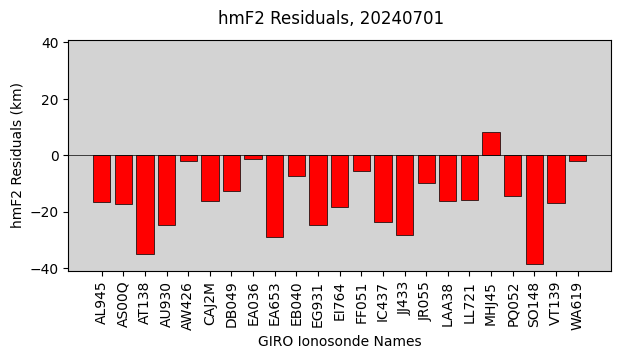

In [3]:

import PyVALION
import PyIRI
import datetime
import numpy as np
import pandas as pd
import os
import pickle


# In this example, we will create a model output using the PyIRI module
# You can provide your own model output for the validation

# Folder where the downloaded ionosonde data will be saved
data_save_dir = '/data/vmakarevich/Download/GIRO_Data/'

# Folder where the processed data will be saved
save_res_dir = '/data/vmakarevich/Download/Save/'

# Name of the validation run
name_run = 'PyIRI_Validation'

# Select the desired day for validation
year = 2024
month = 7
day = 1

# Create a datetime object for the selected day
dtime = datetime.datetime(year, month, day)
print('Validation day is: ', dtime)

# Create an array for the model's time resolution
# In this example, we use 15-minute resolution
atime = pd.to_datetime(np.arange(dtime,
                                 dtime + datetime.timedelta(days=1),
                                 datetime.timedelta(minutes=15)))

# Convert atime to an array of decimal hours
aUT = atime.hour + atime.minute / 60. + atime.second / 3600.

# Provide the F10.7 value for this day
# You can look it up at OMNIWeb: https://omniweb.gsfc.nasa.gov/form/dx1.html
F107 = 174.

# Create a model grid
dlon = 4
dlat = 2
alon = np.arange(-180, 180 + dlon, dlon)
alat = np.arange(-90, 90 + dlat, dlat)
alon_reg_2d, alat_reg_2d = np.meshgrid(alon, alat)
aalt = np.arange(100, 1000, 10)

# Sizes of the grid
N_lon = alon.size
N_lat = alat.size
N_time = aUT.size
N_alt = aalt.size

# Flatten grid arrays
alon_reg = np.reshape(alon_reg_2d, alon_reg_2d.size)
alat_reg = np.reshape(alat_reg_2d, alon_reg_2d.size)

# Run PyIRI
F2, _, _, _, _, _, den = PyIRI.main_library.IRI_density_1day(dtime.year,
                                                             dtime.month,
                                                             dtime.day,
                                                             aUT,
                                                             alon_reg,
                                                             alat_reg,
                                                             aalt,
                                                             F107,
                                                             PyIRI.coeff_dir,
                                                             ccir_or_ursi=1)

# Record the model outputs into a dictionary
# When using your own model, match the format to this dictionary
model = {}
model['NmF2'] = np.reshape(F2['Nm'], (N_time, N_lat, N_lon))
model['hmF2'] = np.reshape(F2['hm'], (N_time, N_lat, N_lon))

# A dictionary to hold the units of the model outputs
units = {}
units['NmF2'] = 'm$^{-3}$'
units['hmF2'] = 'km'

print('The model output has the following', len(model),
      'parameters with shape (N_time, N_lat, N_lon): ')
for key in model:
    print(key, ', shape ', model[key].shape)

# IMPORTANT: Ensure that all arrays in the model dictionary have the same shape
# otherwise, a single forward operator G cannot be applied to all of them
# consistently

# Open the list of GIRO ionosondes (provided by the PyVALION module)
file_ion_name = os.path.join(PyVALION.giro_names_dir, 'GIRO_Ionosondes.p')
giro_name = pickle.load(open(file_ion_name, 'rb'))

# Download all GIRO ionosonde parameters for the validation time
# If you need to exclude certain ionosondes, modify the giro_name['name'] array
raw_data = PyVALION.library.download_GIRO_parameters(atime[0],
                                                     atime[-1],
                                                     giro_name['name'],
                                                     data_save_dir,
                                                     save_res_dir,
                                                     name_run,
                                                     clean_directory=True,
                                                     filter_CS=90)

# Create a forward operator for the ionosonde dataset using the given model
# grid
obs_data, obs_units, G, obs_info = PyVALION.library.find_G_and_y(atime,
                                                                 alon,
                                                                 alat,
                                                                 raw_data,
                                                                 save_res_dir,
                                                                 name_run,
                                                                 True)

# Find residuals between the observed data and model forecast
model_data, residuals, model_units, res_ion = PyVALION.library.find_residuals(
    model, G, obs_data, obs_info, units)

# Create a map showing the locations of GIRO ionosondes used on the selected
# validation day
PyVALION.plotting.plot_ionosondes(obs_info,
                                  dtime,
                                  save_res_dir,
                                  plot_name='Ionosondes_Map')

# Create a histogram of residuals between model data and observations
PyVALION.plotting.plot_histogram(residuals,
                                 model_units,
                                 dtime,
                                 save_res_dir,
                                 plot_name='Residuals')

# Create a plot with mean residuals between model data and observations
# for each ionosonde
PyVALION.plotting.plot_individual_mean_residuals(res_ion,
                                                 obs_info,
                                                 model_units,
                                                 dtime,
                                                 save_res_dir,
                                                 plot_name='IonRes')